In [1]:
import cudf
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from scipy.stats import dweibull, skew, kstat, expectile
from seglearn.feature_functions import (willison_amplitude, emg_var, waveform_length, \
                      slope_sign_changes, zero_crossing, hist, mean_crossings, \
                      mse, means_abs_diff, variation)
import scipy.stats as sts
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt
from tsfresh.feature_extraction import feature_calculators as ts_calcs
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix
import itertools
from catboost import CatBoostClassifier,CatBoostRegressor,Pool,cv
import warnings
warnings.simplefilter('ignore', np.RankWarning)

In [2]:
!nvidia-smi

Sun Mar 10 18:15:40 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   25C    P0    57W / 400W |    419MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
transaction_data = cudf.read_csv('./transactions.csv',parse_dates=['transaction_dttm'])
clients_data = cudf.read_csv('./clients.csv')
train_data = cudf.read_csv('./train.csv')
report_data = cudf.read_csv('./report_dates.csv')
simple_sol = cudf.read_csv('./sample_submit_naive.csv')
reports_data = cudf.read_csv('report_dates.csv',parse_dates=['report_dt'])

In [4]:
clients_data_merge = clients_data.merge(reports_data)[['report_dt','user_id']]
transaction_data = transaction_data.merge(clients_data_merge)

In [5]:
transaction_data.groupby('user_id').agg('count')['transaction_dttm'].mean()

136.19815625

In [6]:
transaction_data

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,report_dt
0,1444,2,1,-199.111954,2022-01-07 10:05:52,2022-07-31 03:00:00
1,1444,1,1,-276.412872,2022-01-07 10:46:37,2022-07-31 03:00:00
2,1444,2,1,-164.808640,2022-01-08 05:19:22,2022-07-31 03:00:00
3,1444,2,1,-262.828308,2022-01-12 09:13:40,2022-07-31 03:00:00
4,1444,1,1,-184.334808,2022-01-13 07:00:02,2022-07-31 03:00:00
...,...,...,...,...,...,...
13075018,559253,3,1,-90.221107,2023-03-01 18:14:39,2023-06-30 03:00:00
13075019,559253,3,1,-186.262100,2023-03-02 13:07:48,2023-06-30 03:00:00
13075020,559253,3,1,-92.112129,2023-03-10 18:07:37,2023-06-30 03:00:00
13075021,559253,3,1,-92.357025,2023-03-15 12:05:27,2023-06-30 03:00:00


NameError: name 'bgf' is not defined

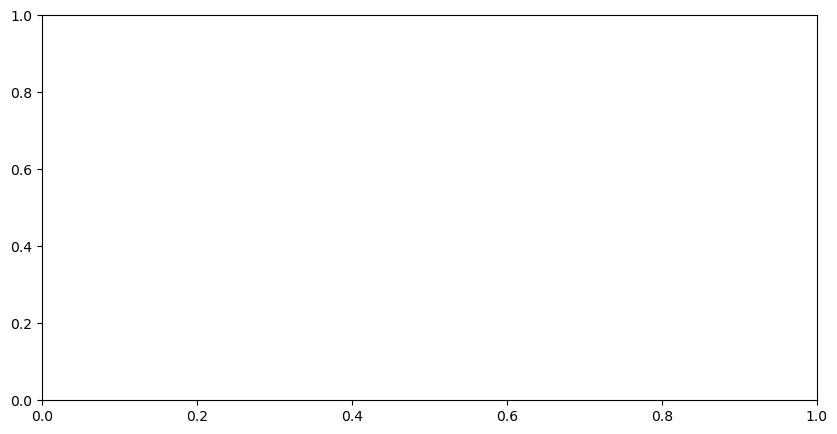

In [7]:
%matplotlib inline
# set figure size
plt.subplots(figsize=(10, 5))
plot_probability_alive_matrix(bgf)
plt.show()

In [8]:
def mounth_count_day(x):
    mounths = [31,28,31,30,31,30,31,31,30,31,30,31]
    return sum(mounths[:x])

def create_time_features(df):
    df['month'] = df['transaction_dttm'].dt.month
    df['day'] = df['transaction_dttm'].dt.day
    df['week'] = df['transaction_dttm'].dt.day.map(lambda x: x // 7)
    df['minute'] = df['transaction_dttm'].dt.minute
    df['second'] = df['transaction_dttm'].dt.second
    df['month_count'] = df['transaction_dttm'].dt.month.map(lambda x: 30 * x)
    df['hour'] = df['transaction_dttm'].dt.hour
    df['year'] = df['transaction_dttm'].dt.year
    
    df['weekofyear'] = df['transaction_dttm'].dt.dayofyear.map(lambda x: x // 7)
    df['dayofweek'] = df['transaction_dttm'].dt.dayofweek
    df['all_day_time'] = df.apply(lambda x:x.hour * 3600 + x.minute * 60 + x.second)
    df['all_week_time'] = df.apply(lambda x:x.dayofweek * 24 + x.hour)
    df['all_year_time'] = df.apply(lambda x: x.month_count + x.day + x.hour / 24)
    df['all_time'] = df.apply(lambda x:(x.year - 2021)*365 + x.month_count + x.day + x.hour / 24)
    df['all_month_time'] = df.apply(lambda x:x.day * 24 + x.hour + x.minute / 60)
    df['all_sec_time'] = df.apply(lambda x: (x.year - 2021)*365 * 24 * 3600 + x.month * 30 * 24 * 3600 + x.day * 24 * 3600 + x.hour * 3600 + x.minute * 60 + x.second)
    df['all_sec_time_report'] = (df['report_dt'].dt.year - 2021)*365 * 24 * 3600 + df['report_dt'].dt.month * 30 * 24 * 3600 + df['report_dt'].dt.day * 24 * 3600 + df['report_dt'].dt.hour * 3600 + df['report_dt'].dt.minute * 60 + df['report_dt'].dt.second
    df['delta_all_sec_time'] = df['all_sec_time_report'] - df['all_sec_time']
    df['hour_time'] = df.apply(lambda x:x.minute * 60 + x.second)
    df['days_to_reprort'] = (df['report_dt'] - df['transaction_dttm']).dt.days
    df['mounth_until_report'] = (df['report_dt'].dt.year-df['transaction_dttm'].dt.year)*12+(df['report_dt'].dt.month-df['transaction_dttm'].dt.month)

    df['cl_early_morning'] = ((df['hour'] > 4) & (df['hour'] <= 8)).astype('int16')
    df['cl_is_weekend'] = (df['dayofweek'] > 4).astype('int16')
    return df

In [9]:
transaction_data = create_time_features(transaction_data)

In [10]:
transaction_data['mounth_until_report'].value_counts()

8    2192218
7    2179348
6    2165299
5    2162299
4    2161568
3    1390998
9     823293
Name: mounth_until_report, dtype: int32

In [11]:
def generate_time_features(df): ## ADD cnt / (max - min)
    time_day_features = df.groupby('user_id')['all_day_time'].agg(['mean', 'std', 'min', 'max', 'median','count'])
    time_day_features.columns = [f'time_day_features_{c}' for c in time_day_features.columns]
    time_day_features['time_day_features_diff'] = time_day_features['time_day_features_max'] - time_day_features['time_day_features_min']
    
    all_sec_features = df.groupby('user_id')['all_sec_time'].agg(['mean', 'std', 'min', 'max', 'median','count','var',lambda x: x.quantile(0.25),lambda x: x.quantile(0.75)])
    all_sec_features.columns = [f'all_sec_time_features_{c}' for c in all_sec_features.columns]
    all_sec_features['all_sec_time_features_diff'] = all_sec_features['all_sec_time_features_max'] - all_sec_features['all_sec_time_features_min']
    all_sec_features['all_sec_time_scale'] = all_sec_features['all_sec_time_features_mean'] - all_sec_features['all_sec_time_features_median']
    
    delta_all_sec_features = df.groupby('user_id')['delta_all_sec_time'].agg(['mean', 'std', 'min', 'max', 'median','count','var',lambda x: x.quantile(0.25),lambda x: x.quantile(0.75)])
    delta_all_sec_features.columns = [f'delta_all_sec_time_features_{c}' for c in delta_all_sec_features.columns]
    delta_all_sec_features['delta_all_sec_features_diff'] = delta_all_sec_features['delta_all_sec_time_features_max'] - delta_all_sec_features['delta_all_sec_time_features_min']
    delta_all_sec_features['delta_all_sec_features_scale'] = delta_all_sec_features['delta_all_sec_time_features_mean'] - delta_all_sec_features['delta_all_sec_time_features_median']


    time_year_featues = df.groupby('user_id')['all_year_time'].agg(['mean', 'std', 'min', 'max', 'median',lambda x: x.quantile(0.25),lambda x: x.quantile(0.75),'count'])
    time_year_featues.columns = [f'time_year_featues_{c}' for c in time_year_featues.columns]
    time_year_featues['time_year_featues_diff'] = time_year_featues['time_year_featues_max'] - time_year_featues['time_year_featues_min']
    time_year_featues['time_year_featues_interval'] = time_year_featues['time_year_featues_count'] / time_year_featues['time_year_featues_diff']  
    

    all_time_featues = df.groupby('user_id')['all_time'].agg(['mean', 'std', 'min', 'max','count','median'])
    all_time_featues.columns = [f'all_time_featues_{c}' for c in all_time_featues.columns]
    all_time_featues['all_time_featues_diff'] = all_time_featues['all_time_featues_count'] / (all_time_featues['all_time_featues_max'] - all_time_featues['all_time_featues_min'])

    time_month_features = df.groupby('user_id')['all_month_time'].agg(['mean', 'std', 'min', 'max', 'median'])
    time_month_features.columns = [f'time_month_features_{c}' for c in time_month_features.columns]
    time_month_features['time_month_features_diff'] = time_month_features['time_month_features_max'] - time_month_features['time_month_features_min']


    dayofweek_embeds = cudf.pivot_table(
                             df,
                             index =['user_id'],
                             values=['transaction_amt'],
                             columns=['dayofweek'],
                             aggfunc=['count','mean','max','std','min']).fillna(0).sort_index() # 'median','sum'
    
    hour_embeds = cudf.pivot_table(
                             df,
                             index =['user_id'],
                             values=['transaction_amt'],
                             columns=['hour'],
                             aggfunc=['count','mean','max','std','min',]).fillna(0).sort_index()
    

    month_embeds = cudf.pivot_table(
                             df,
                             index =['user_id'],
                             values=['transaction_amt'],
                             columns=['month'],
                             aggfunc=['count','mean','max','std','min']).fillna(0).sort_index()
    
    dayofweek_embeds = cudf.DataFrame(dayofweek_embeds.values)
    hour_embeds = cudf.DataFrame(hour_embeds.values)
    month_embeds = cudf.DataFrame(month_embeds.values)
    
    dayofweek_embeds.columns = [f'dayofweek_embeds_{i}' for i in dayofweek_embeds.columns]
    hour_embeds.columns = [f'hour_embeds_{i}' for i in hour_embeds.columns]
    month_embeds.columns = [f'month_embeds_{i}' for i in month_embeds.columns]
    
    dayofweek_embeds.index = time_day_features.index
    hour_embeds.index = time_day_features.index
    month_embeds.index = time_day_features.index

    
    time_feartures = cudf.concat([time_day_features.sort_index(),
                                time_year_featues.sort_index(),
                                delta_all_sec_features.sort_index(),
                                time_month_features.sort_index(),
                                all_time_featues.sort_index(),
                                all_sec_features.sort_index(),
                                dayofweek_embeds,
                                hour_embeds,
                                month_embeds],axis=1)

    return time_feartures

In [12]:
def generate_time_features_factors(df,idx):
    df['operations_type'] = df['transaction_amt'].map(lambda x: 1 if x >= 0 else 0)
    
    all_sec_oper_embeds = cudf.pivot_table(
                             df,
                             index =['user_id'],
                             values=['all_sec_time'],
                             columns=['operations_type'],
                             aggfunc=['mean', 'std', 'min', 'max', 'median','count','var','last',
                                      lambda x: x.quantile(0.25),lambda x: x.quantile(0.75)]).fillna(0).sort_index()
    
    all_month_oper_embeds = cudf.pivot_table(
                             df,
                             index =['user_id'],
                             values=['all_month_time'],
                             columns=['operations_type'],
                             aggfunc=['mean', 'std', 'min', 'max', 'median','count','var','last',
                                      lambda x: x.quantile(0.25),lambda x: x.quantile(0.75)]).fillna(0).sort_index()
        
    all_day_oper_embeds = cudf.pivot_table(
                             df,
                             index =['user_id'],
                             values=['all_day_time'],
                             columns=['operations_type'],
                             aggfunc=['mean', 'std', 'min', 'max', 'median','count','var','last',
                                      lambda x: x.quantile(0.25),lambda x: x.quantile(0.75)]).fillna(0).sort_index()
    
    
    all_sec_oper_embeds = cudf.DataFrame(all_sec_oper_embeds.values)
    all_month_oper_embeds = cudf.DataFrame(all_month_oper_embeds.values)
    all_day_oper_embeds = cudf.DataFrame(all_day_oper_embeds.values)
    
    all_sec_oper_embeds.columns = [f'all_sec_oper_embeds_{i}' for i in all_sec_oper_embeds.columns]
    all_month_oper_embeds.columns = [f'all_month_oper_embeds_{i}' for i in all_month_oper_embeds.columns]
    all_day_oper_embeds.columns = [f'all_day_oper_embeds_{i}' for i in all_day_oper_embeds.columns]
    
    all_sec_oper_embeds.index = idx
    all_month_oper_embeds.index = idx
    all_day_oper_embeds.index = idx                         

    time_feartures = cudf.concat([all_sec_oper_embeds,
                                 all_month_oper_embeds,
                                 all_day_oper_embeds],axis=1)

    return time_feartures

In [13]:
def get_corr_cov_features(df):
    feat_year_time_corr_ps = df[['transaction_amt','all_sec_time','user_id']].to_pandas().groupby('user_id').corr('pearson')
    feat_year_time_corr_ps = feat_year_time_corr_ps.values[:,1][::2]
    feat_year_time_corr_sp = df[['transaction_amt','all_time','user_id']].to_pandas().groupby('user_id').corr('spearman')
    feat_year_time_corr_sp = feat_year_time_corr_sp.values[:,1][::2]
    
    feat_hour_corr_ps = df[['transaction_amt','hour','user_id']].to_pandas().groupby('user_id').corr('pearson')
    feat_hour_corr_ps = feat_hour_corr_ps.values[:,1][::2]
    feat_hour_corr_sp = df[['transaction_amt','hour','user_id']].to_pandas().groupby('user_id').corr('spearman')
    feat_hour_corr_sp = feat_hour_corr_sp.values[:,1][::2]
    
    feat_dayofweek_corr_ps = df[['transaction_amt','dayofweek','user_id']].to_pandas().groupby('user_id').corr('pearson')
    feat_dayofweek_corr_ps = feat_dayofweek_corr_ps.values[:,1][::2]
    feat_dayofweek_corr_sp = df[['transaction_amt','dayofweek','user_id']].to_pandas().groupby('user_id').corr('spearman')
    feat_dayofweek_corr_sp = feat_dayofweek_corr_sp.values[:,1][::2]
    
    feat_year_time_cov = df[['transaction_amt','all_sec_time','user_id']].to_pandas().groupby('user_id').cov()
    feat_year_time_cov_0 = feat_year_time_cov.values[:,1][::2]
    feat_year_time_cov_1 = feat_year_time_cov.values[:,0][::2]
    
    feat_hour_cov = df[['transaction_amt','hour','user_id']].to_pandas().groupby('user_id').cov()
    feat_hour_cov_0 = feat_year_time_cov.values[:,1][::2]
    feat_hour_cov_1 = feat_year_time_cov.values[:,0][::2]    

    feat_dayofweek_cov = df[['transaction_amt','dayofweek','user_id']].to_pandas().groupby('user_id').cov()
    feat_dayofweek_cov_0 = feat_year_time_cov.values[:,1][::2]
    feat_dayofweek_cov_1 = feat_year_time_cov.values[:,0][::2]    
    
    feature_df = cudf.DataFrame({'feat_year_time_corr_ps':feat_year_time_corr_ps,
                               'feat_year_time_corr_sp':feat_year_time_corr_sp,
                               'feat_hour_corr_ps':feat_hour_corr_ps,
                               'feat_hour_corr_sp':feat_hour_corr_sp,
                               'feat_dayofweek_corr_ps':feat_dayofweek_corr_ps,
                               'feat_dayofweek_corr_sp':feat_dayofweek_corr_sp,
                               'feat_year_time_cov_0':feat_year_time_cov_0,
                               'feat_year_time_cov_1':feat_year_time_cov_1,
                               'feat_hour_cov_0':feat_hour_cov_0,
                               'feat_hour_cov_1':feat_hour_cov_1,
                               'feat_dayofweek_cov_0':feat_dayofweek_cov_0,
                               'feat_dayofweek_cov_1':feat_dayofweek_cov_1})
    return feature_df

In [14]:
def scipy_features(df):
    df['delta_all_sec_time_abs'] = df['delta_all_sec_time'].abs()
    group = df[['delta_all_sec_time_abs','user_id']].to_pandas().groupby('user_id')['delta_all_sec_time_abs']
    
    features = cudf.DataFrame()
    features['delta_time_differential_entropy'] = group.progress_aggregate(lambda x: sts.differential_entropy(x.values))
    features['delta_time_entropy'] = group.progress_aggregate(lambda x: sts.entropy(x.values))    

    
    return features

In [15]:
def tsfresh_features(df):
    df['delta_all_sec_time_abs'] = df['delta_all_sec_time'].abs()
    group = df[['delta_all_sec_time_abs','user_id']].to_pandas().groupby('user_id')['delta_all_sec_time_abs']
    
    feature_df = cudf.DataFrame()
    feature_df['delta_time_app_entropy'] = group.progress_aggregate(lambda x: ts_calcs.approximate_entropy(x.values,1,0))
    feature_df['delta_time_app_entropyV2'] = group.progress_aggregate(lambda x: ts_calcs.approximate_entropy(x.values,2,1))
    
    # DEL
    #feature_df['delta_time_auto_corr_median_lg'] = group.progress_aggregate(lambda x: ts_calcs.agg_linear_trend(x.values,param=[{'f_agg':'median','maxlag':5}])[0][1])
    #feature_df['delta_time_auto_corr_median_sm'] = group.progress_aggregate(lambda x: ts_calcs.agg_linear_trend(x.values,param=[{'f_agg':'median','maxlag':1,'chunk_len':16}])[0][1])
    #feature_df['delta_time_auto_corr_std_sm'] = group.progress_aggregate(lambda x: ts_calcs.agg_linear_trend(x.values,param=[{'f_agg':'std','maxlag':5,'chunk_len':16}])[0][1])
    #feature_df['delta_time_auto_corr_std_lg'] = group.progress_aggregate(lambda x: ts_calcs.agg_linear_trend(x.values,param=[{'f_agg':'std','maxlag':1,'chunk_len':16}])[0][1])
    #feature_df['delta_time_auto_corr_sum_sm'] = group.progress_aggregate(lambda x: ts_calcs.agg_linear_trend(x.values,param=[{'f_agg':'sum','maxlag':5,'chunk_len':16}])[0][1])
    #feature_df['delta_time_auto_corr_sum_lg'] = group.progress_aggregate(lambda x: ts_calcs.agg_linear_trend(x.values,param=[{'f_agg':'sum','maxlag':5,'chunk_len':16}])[0][1])
    
    feature_df['delta_time_aug_dcf_teststat_AIC'] = group.progress_aggregate(lambda x: ts_calcs.augmented_dickey_fuller(x.values,param=[{'attr':'teststat','autolag':'AIC'}])[0][1])
    feature_df['delta_time_aug_dcf_teststat_AIC'] = group.progress_aggregate(lambda x: ts_calcs.augmented_dickey_fuller(x.values,param=[{'attr':'p_value','autolag':'AIC'}])[0][1])
    
    feature_df['delta_time_autocorrelation_5'] = group.progress_aggregate(lambda x: ts_calcs.autocorrelation(x.values,5))
    feature_df['delta_time_autocorrelation_1'] = group.progress_aggregate(lambda x: ts_calcs.autocorrelation(x.values,1))
    
    feature_df['delta_time_benford'] = group.progress_aggregate(lambda x: ts_calcs.benford_correlation(x.values))
    feature_df['delta_time_bin_entr_5'] = group.progress_aggregate(lambda x: ts_calcs.binned_entropy(x.values,5))
    feature_df['delta_time_bin_entr_32'] = group.progress_aggregate(lambda x: ts_calcs.binned_entropy(x.values,32))
    feature_df['delta_time_c3_4'] = group.progress_aggregate(lambda x: ts_calcs.c3(x.values,4))
    feature_df['delta_time_c3_6'] = group.progress_aggregate(lambda x: ts_calcs.c3(x.values,6))
    feature_df['delta_time_c3_12'] = group.progress_aggregate(lambda x: ts_calcs.c3(x.values,12))
    
    feature_df['delta_time_q_f1'] = group.progress_aggregate(lambda x: ts_calcs.change_quantiles(x.values,0.25,0.75,False,'std'))
    feature_df['delta_time_q_f2'] = group.progress_aggregate(lambda x: ts_calcs.change_quantiles(x.values,0.1,0.9,True,'std'))
    feature_df['delta_time_q_f3'] = group.progress_aggregate(lambda x: ts_calcs.change_quantiles(x.values,0.25,0.75,False,'mean'))
    feature_df['delta_time_q_f4'] = group.progress_aggregate(lambda x: ts_calcs.change_quantiles(x.values,0.35,0.65,False,'median'))
    
    feature_df['delta_time_cid_ce'] = group.progress_aggregate(lambda x: ts_calcs.cid_ce(x.values,False))
    feature_df['delta_time_cid_ce_norm'] = group.progress_aggregate(lambda x: ts_calcs.cid_ce(x.values,True))
    
    feature_df['delta_time_enrg_ratio_bch_1'] = group.progress_aggregate(lambda x: ts_calcs.energy_ratio_by_chunks(x.values,param=[{"num_segments": 10, "segment_focus": 2}])[0][1])
    feature_df['delta_time_enrg_ratio_bch_2'] = group.progress_aggregate(lambda x: ts_calcs.energy_ratio_by_chunks(x.values,param=[{"num_segments": 20, "segment_focus": 4}])[0][1])
    feature_df['delta_time_enrg_ratio_bch_3'] = group.progress_aggregate(lambda x: ts_calcs.energy_ratio_by_chunks(x.values,param=[{"num_segments": 30, "segment_focus": 6}])[0][1])
    
    feature_df['delta_time_first_loc_max'] = group.progress_aggregate(lambda x: ts_calcs.first_location_of_maximum(x.values))
    feature_df['delta_time_first_loc_min'] = group.progress_aggregate(lambda x: ts_calcs.first_location_of_minimum(x.values))
    feature_df['delta_time_last_loc_max'] = group.progress_aggregate(lambda x: ts_calcs.last_location_of_maximum(x.values))
    feature_df['delta_time_last_loc_min'] = group.progress_aggregate(lambda x: ts_calcs.last_location_of_minimum(x.values))

    
    feature_df['delta_time_frorier_entropy'] = group.progress_aggregate(lambda x: ts_calcs.fourier_entropy(x.values,8))
    feature_df['delta_time_frorier_entropy_16'] = group.progress_aggregate(lambda x: ts_calcs.fourier_entropy(x.values,16))
    feature_df['delta_time_first_q_mass_25'] = group.progress_aggregate(lambda x: ts_calcs.index_mass_quantile(x.values,param=[{'q':0.25}])[0][1])
    feature_df['delta_time_first_q_mass_75'] = group.progress_aggregate(lambda x: ts_calcs.index_mass_quantile(x.values,param=[{'q':0.75}])[0][1])
    feature_df['delta_time_LDR'] = group.progress_aggregate(lambda x: ts_calcs.large_standard_deviation(x.values,0.1))
    feature_df['delta_time_ZIV'] = group.progress_aggregate(lambda x: ts_calcs.lempel_ziv_complexity(x.values,2))
    
    feature_df['delta_time_longest_strike_above_mean'] = group.progress_aggregate(lambda x: ts_calcs.longest_strike_above_mean(x.values))
    feature_df['delta_time_longest_strike_below_mean'] = group.progress_aggregate(lambda x: ts_calcs.longest_strike_below_mean(x.values))
    feature_df['delta_time_max_langevin_fixed_point'] = group.progress_aggregate(lambda x: ts_calcs.max_langevin_fixed_point(x.values,5,5))
    feature_df['delta_time_mean_second_derivative_central'] = group.progress_aggregate(lambda x: ts_calcs.mean_second_derivative_central(x.values))
    feature_df['delta_time_number_cwt_peaks'] = group.progress_aggregate(lambda x: ts_calcs.number_cwt_peaks(x.values,12))
    
    feature_df['delta_time_number_peaks_2'] = group.progress_aggregate(lambda x: ts_calcs.number_peaks(x.values,2))
    feature_df['delta_time_number_peaks_6'] = group.progress_aggregate(lambda x: ts_calcs.number_peaks(x.values,6))
    feature_df['delta_time_number_peaks_15'] = group.progress_aggregate(lambda x: ts_calcs.number_peaks(x.values,15))    
    
    feature_df['delta_time_HUETA_v1'] = group.progress_aggregate(lambda x: ts_calcs.percentage_of_reoccurring_datapoints_to_all_datapoints(x.values))
    feature_df['delta_time_HUETA_v2'] = group.progress_aggregate(lambda x: ts_calcs.percentage_of_reoccurring_values_to_all_values(x.values))
    feature_df['delta_time_HUETA_v3'] = group.progress_aggregate(lambda x: ts_calcs.permutation_entropy(x.values,1,3))
    feature_df['delta_time_HUETA_v4'] = group.progress_aggregate(lambda x: ts_calcs.ratio_beyond_r_sigma(x.values,0.5))
    feature_df['delta_time_HUETA_v5'] = group.progress_aggregate(lambda x: ts_calcs.sample_entropy(x.values))
    
    feature_df['delta_time_skewness'] = group.progress_aggregate(lambda x: ts_calcs.skewness(x.values)) 
    #feature_df['delta_time_spkt_welch_density'] = group.progress_aggregate(lambda x: ts_calcs.spkt_welch_density(x.values,param=[{'coeff':0.25}])[0][1]) DL
    #feature_df['delta_time_spkt_welch_density-05'] = group.progress_aggregate(lambda x: ts_calcs.spkt_welch_density(x.values,param=[{'coeff':0.5}])[0][1]) DL
    feature_df['delta_time_sum_of_reoccurring_data_points'] = group.progress_aggregate(lambda x: ts_calcs.sum_of_reoccurring_data_points(x.values))
    feature_df['delta_time_sum_of_reoccurring_values'] = group.progress_aggregate(lambda x: ts_calcs.sum_of_reoccurring_values(x.values))
    feature_df['delta_time_time_reversal_asymmetry_statistic'] = group.progress_aggregate(lambda x: ts_calcs.time_reversal_asymmetry_statistic(x.values,1))
    feature_df['delta_time_time_reversal_asymmetry_statistic_4'] = group.progress_aggregate(lambda x: ts_calcs.time_reversal_asymmetry_statistic(x.values,4))
    
    return feature_df 

In [16]:
def prepare_mcc(df):
    value_counts = transaction_data['mcc_code'].value_counts()
    important_mcc = value_counts[value_counts > 40_000].index.values.tolist()
    df['important_mcc'] = [x if x in important_mcc else -1 for x in df['mcc_code'].to_pandas()]
    return df

transaction_data = prepare_mcc(transaction_data)

In [17]:
def make_money_features(df):
    simple_features = df.groupby('user_id')['transaction_amt'].agg(['mean', 'std', 'min', 'max', 'median','sum',lambda x:x.quantile(0.25),lambda x: x.quantile(0.75)])
    simple_features.columns = [f'simple_features_{c}' for c in simple_features.columns]
    simple_features['simple_features_diff'] = simple_features['simple_features_max'] - simple_features['simple_features_min']
    simple_features['simple_features_step'] =  simple_features['simple_features_mean'] / simple_features['simple_features_diff']
    
    month_embeds = cudf.pivot_table(
                             df,
                             index =['user_id'],
                             values=['transaction_amt'],
                             columns=['important_mcc'],
                             aggfunc=['count','mean','max','std','min','median']).fillna(0).sort_index()
    
    #df['currency_rk'] = df['currency_rk'].apply(lambda x: 0 if x > 1 else x)
    curr_embeds = cudf.pivot_table(
                             df,
                             index =['user_id'],
                             values=['transaction_amt'],
                             columns=['currency_rk'],
                             aggfunc=['count','mean','max','std','min','median']).fillna(0).sort_index()

    
    month_embeds = cudf.DataFrame(month_embeds.values)
    month_embeds.columns = [f'mony_embeds_{i}' for i in month_embeds.columns]
    month_embeds.index = simple_features.index
    
    curr_embeds = cudf.DataFrame(curr_embeds.values)
    curr_embeds.columns = [f'curr_embeds_{i}' for i in curr_embeds.columns]
    curr_embeds.index = simple_features.index

    
    money_features = cudf.concat([simple_features.sort_index(),
                                curr_embeds,month_embeds],axis=1)

    return money_features

def make_money_features_factors(df):
    df['operations_type'] = df['transaction_amt'].map(lambda x: 1 if x >= 0 else 0)
    df['transaction_amt_abs'] = df['transaction_amt'].abs()
    simple_features = df.groupby('user_id')['operations_type'].agg(['mean', 'std', 'min', 'max', 'median'])
    simple_features.columns = [f'simple_opr_features_{c}' for c in simple_features.columns]
    
    simple_oper_embeds = cudf.pivot_table(
                             df,
                             index =['user_id'],
                             values=['transaction_amt_abs'],
                             columns=['operations_type'],
                             aggfunc=['count','mean','max','std','min','median','sum',lambda x:x.quantile(0.25),lambda x: x.quantile(0.75)]).fillna(0).sort_index()

    #mcc_oper_embeds = cudf.pivot_table(
    #                         transaction_data,
    #                         index =['user_id'],
    #                         values=['transaction_amt_abs'],
    #                         columns=['important_mcc','operations_type'],
    #                         aggfunc=['count','mean','max','std','min','median']).fillna(0).sort_index()
    
    #mcc_oper_embeds = cudf.DataFrame(mcc_oper_embeds.values)
    #mcc_oper_embeds.columns = [f'mony_oper_embeds_{i}' for i in mcc_oper_embeds.columns]
    #mcc_oper_embeds.index = simple_features.index
    
    simple_oper_embeds = cudf.DataFrame(simple_oper_embeds.values)
    simple_oper_embeds.columns = [f'simple_oper_embeds_{i}' for i in simple_oper_embeds.columns]
    simple_oper_embeds.index = simple_features.index

    
    money_features = cudf.concat([simple_features.sort_index(),simple_oper_embeds],axis=1)

    return money_features

In [18]:
def time_mcc_feature(df,idxes):
    
    time_mcc_embeds = cudf.pivot_table(
                             transaction_data,
                             index =['user_id'],
                             values=['all_year_time'],
                             columns=['important_mcc','operations_type'],
                             aggfunc=['mean','max','std','min','median','last']).fillna(-1).sort_index()
    
    time_mcc_embeds = cudf.DataFrame(time_mcc_embeds.values)
    time_mcc_embeds.columns = [f'time_mcc_embeds_{i}' for i in time_mcc_embeds.columns]
    time_mcc_embeds.index = idxes
    
    return time_mcc_embeds

def time_oper_feature(df,idxes):
    
    time_oper_feature = cudf.pivot_table(
                             transaction_data,
                             index =['user_id'],
                             values=['delta_all_sec_time'],
                             columns=['operations_type'],
                             aggfunc=['mean','max','std','min','median','var','last']).fillna(-1).sort_index()
    
    time_oper_feature = cudf.DataFrame(time_oper_feature.values)
    time_oper_feature.columns = [f'time_oper_embeds_{i}' for i in time_oper_feature.columns]
    time_oper_feature.index = idxes
    
    return time_oper_feature

def distance_calc_step_5(x,step=5):
    dist = []
    num_steps = len(x) // 5 -1
    for i in range(num_steps):
        dist += [sum(x[i*5:(i+1)*5]) - sum(x[(i+1)*5:(i+2)*5])]
    
    if dist == []:
        return [-1,-1]
    return dist

def distance_calc(x):
    dist = []
    for i in range(len(x)-1):
        dist += [x[i+1] - x[i]]
    return dist

def calc_corr_synth(x):
    return cudf.DataFrame({'feature':x,'idx':range(len(x))}).corr()['feature']['idx']
    
def polifit_second(x):
    if len(x) % 2 == 0:
        return np.polyfit(range(len(x) // 2), x[len(x) // 2:], 1)[1]
    else:
        return np.polyfit(range(len(x) // 2 + 1), x[len(x) // 2:], 1)[1]


def shift_features(df,shifter_f=distance_calc):
    df_pandas = df[['user_id','all_sec_time']].to_pandas()
    
    times_featues = df_pandas.groupby('user_id').agg(lambda x:sorted(x.tolist()))
    times_featues['distances'] = times_featues['all_sec_time'].map(shifter_f)
    
    feature_df = cudf.DataFrame()
    feature_df['time_step_max'] = times_featues['distances'].progress_map(np.max)
    feature_df['time_step_min'] = times_featues['distances'].progress_map(np.min)
    feature_df['time_step_mean'] = times_featues['distances'].progress_map(np.mean)
    feature_df['time_step_std'] = times_featues['distances'].progress_map(np.std)
    feature_df['time_step_median'] = times_featues['distances'].progress_map(np.median)
    feature_df['time_step_q_75'] = times_featues['distances'].progress_map(lambda x:np.quantile(x,0.75))
    feature_df['time_step_q_25'] = times_featues['distances'].progress_map(lambda x:np.quantile(x,0.25))
    feature_df['time_step_q_90'] = times_featues['distances'].progress_map(lambda x:np.quantile(x,0.90))
    feature_df['time_step_dist_entropy'] = times_featues['distances'].progress_map(lambda x: sts.differential_entropy(x))
    #feature_df['time_step_q_55'] = times_featues['distances'].progress_map(lambda x:np.quantile(x,0.55))
    #feature_df['time_step_q_45'] = times_featues['distances'].progress_map(lambda x:np.quantile(x,0.45))
    #feature_df['synth_corr'] = times_featues['distances'].progress_map(calc_corr_synth)
    feature_df['time_step_polyfit'] = times_featues['distances'].progress_map(lambda x:np.polyfit(range(len(x)), x, 1)[1])
    feature_df['time_step_polyfit_st'] = times_featues['distances'].progress_map(lambda x:np.polyfit(range(len(x)), x, 1)[0])
    feature_df['time_step_polyfit_first_per'] = times_featues['distances'].progress_map(lambda x:np.polyfit(range(len(x) // 2), x[:len(x) // 2], 1)[1])
    feature_df['time_step_polyfit_second_per'] = times_featues['distances'].progress_map(polifit_second)
    feature_df['time_step_polyfit_otn'] = feature_df['time_step_polyfit_first_per'] - feature_df['time_step_polyfit_second_per']
    
    feature_df['time_step_skew'] = times_featues['distances'].progress_map(lambda x: skew(x))
    feature_df['time_step_last'] = times_featues['distances'].progress_map(lambda x: x[-1])
    #feature_df['time_step_kstat'] = times_featues['distances'].progress_map(lambda x: kstat(x))
    #feature_df['time_step_expectile'] = times_featues['distances'].progress_map(lambda x: sts.expectile(x))
    #feature_df['time_step_moment'] = times_featues['distances'].progress_map(lambda x: sts.moment(x))
    #feature_df['time_step_kurtosis'] = times_featues['distances'].progress_map(lambda x: sts.kurtosis(x))
    #feature_df['time_step_hmean'] = times_featues['distances'].progress_map(lambda x: sts.hmean(x))
    #feature_df['time_step_kstatvar'] = times_featues['distances'].progress_map(lambda x: sts.kstatvar(x))
    #feature_df['time_step_iqr'] = times_featues['distances'].progress_map(lambda x: sts.iqr(x))
    #feature_df['time_step_entropy'] = times_featues['distances'].progress_map(lambda x: sts.entropy(x))

    #feature_df['time_step_polyfit_st_2'] = times_featues['distances'].progress_map(lambda x:np.polyfit(range(len(x)), x, 2)[2])
    feature_df.index = times_featues.index.tolist()
    
    return feature_df

In [19]:
def calc_counts_oper_per(x,step=604800):
    x = np.array(x)
    step = 604800 // 5
    prep_features = []
    end_val = x[-1]
    step_end = x[0]
    step_sart = -1
    
    while step_end <= end_val:
        step_sart = step_end
        step_end += step
        prep_features += [len(x[(x >= step_sart) & (x <= step_end)])]
    
    return prep_features

def time_brutforce(df):
    df_pandas = df[['user_id','all_sec_time']].to_pandas()
    
    times_featues = df_pandas.groupby('user_id').agg(lambda x:sorted(x.tolist()))
    times_featues['counts'] = times_featues['all_sec_time'].progress_map(calc_counts_oper_per)
    
    feature_df = cudf.DataFrame()
    feature_df['hard_time_step_count'] = times_featues['counts'].progress_map(len)
    feature_df['hard_time_step_count_0'] = times_featues['counts'].progress_map(lambda x:x.count(0))
    feature_df['hard_time_step_max'] = times_featues['counts'].progress_map(np.max)
    feature_df['hard_time_step_min'] = times_featues['counts'].progress_map(np.min)
    feature_df['hard_time_step_mean'] = times_featues['counts'].progress_map(np.mean)
    feature_df['hard_time_step_std'] = times_featues['counts'].progress_map(np.std)
    feature_df['hard_time_step_median'] = times_featues['counts'].progress_map(np.median)
    feature_df['hard_time_step_q_25'] = times_featues['counts'].progress_map(lambda x:np.quantile(x,0.75))
    feature_df['hard_time_step_q_75'] = times_featues['counts'].progress_map(lambda x:np.quantile(x,0.25))
    #feature_df['hard_time_step_polyfit'] = times_featues['counts'].progress_map(lambda x:np.polyfit(range(len(x)), x, 1)[1])
    #feature_df['hard_time_step_polyfit_st'] = times_featues['counts'].progress_map(lambda x:np.polyfit(range(len(x)), x, 1)[0])
    feature_df.index = times_featues.index.tolist()
    
    return feature_df

def nununique_features(df):
    df_pandas = df[['user_id','days_to_reprort']].to_pandas()
    
    times_featues = df_pandas.groupby('user_id').agg(lambda x:sorted(x.tolist()))
    times_featues['steps'] = times_featues['days_to_reprort'].map(np.diff)

    feature_df = cudf.DataFrame()
    feature_df['mcc_nuniue'] = df.groupby('user_id')['mcc_code'].nunique()
    feature_df['hour_nuniue'] = df.groupby('user_id')['hour'].nunique()
    feature_df['days_nuniue'] = df.groupby('user_id')['days_to_reprort'].nunique()
    feature_df['currency_nuniue'] = df.groupby('user_id')['currency_rk'].nunique()
    feature_df['step_nuniue'] = times_featues['steps'].map(lambda x:len(np.unique(x)))
    return feature_df

def get_top_k_v2(df,sample_rate=0.1,min_sample=60):
    counts = df.groupby('user_id')['mcc_code'].agg('count')
    counts = counts.sort_index().values.tolist()
    idxes = []
    for x in counts:
        idxes += list(range(x))
        
    df['idx_of_transaction'] = idxes
    df['transaction_amt_abs'] = df['transaction_amt'].abs()
    df['all_transaction_count'] = df.groupby('user_id')['mcc_code'].transform('count')
    df['is_last_sample'] = df.apply(lambda x: x.idx_of_transaction >= x.all_transaction_count * (1 - sample_rate))
    df_top_k = df[(df['all_transaction_count'] >= min_sample) & (df['is_last_sample'])]
    
    print(df_top_k.groupby('user_id')['mcc_code'].count().min())
    time_features = generate_time_features(df_top_k)
    time_features_oper = generate_time_features_factors(df_top_k,time_features.index)

    sts_features = scipy_features(df_top_k)
    corr_features = get_corr_cov_features(df_top_k)
    corr_features.index = time_features.index
    shift_feature = shift_features(df_top_k)
    #bytd_features = calc_simple_byrd_features(df_top_k)
    #brut_force_v2 = time_brutforce(transaction_data)

    mony_features = make_money_features_factors(df_top_k)
    nununique_feature = nununique_features(df_top_k)
    return cudf.concat([mony_features,nununique_feature,shift_feature,sts_features,time_features,time_features_oper,corr_features],axis=1)

def get_top_k(df,period=122.5,min_sample=10):
    df_top_k = df[df['days_to_reprort'] <= period].copy()
    df_top_k['count_tr'] = df_top_k.groupby('user_id')['mcc_code'].transform('count')
    df_top_k = df_top_k[df_top_k['count_tr'] > min_sample]
    
    print(df_top_k.groupby('user_id').agg('count')['transaction_dttm'].mean())
    
    time_features = generate_time_features(df_top_k)
    time_features_oper = generate_time_features_factors(df_top_k,time_features.index)

    sts_features = scipy_features(df_top_k)
    corr_features = get_corr_cov_features(df_top_k)
    corr_features.index = time_features.index
    shift_feature = shift_features(df_top_k)
    #bytd_features = calc_simple_byrd_features(df_top_k)
    #brut_force_v2 = time_brutforce(transaction_data)

    mony_features = make_money_features_factors(df_top_k)
    nununique_feature = nununique_features(df_top_k)
    return cudf.concat([mony_features,nununique_feature,shift_feature,sts_features,time_features,time_features_oper,corr_features],axis=1)


def last_count(df,bins=[5,10,15,20,25,30,35,45,50,60]):
    df['transaction_amt_abs'] = df['transaction_amt'].abs()
    feature_df = cudf.DataFrame(index=df.groupby('user_id')['mcc_code'].agg('count').index)
    for x in bins:
        feature_df[f'count_{x}_prev'] = df[df['days_to_reprort'] > x + 100].groupby('user_id')['mcc_code'].agg('count')
        feature_df[f'count_{x}_last'] = df[df['days_to_reprort'] <= x + 100].groupby('user_id')['mcc_code'].agg('count')
        feature_df[f'percent_{x}'] =  feature_df[f'count_{x}_last'] / (feature_df[f'count_{x}_last'] + feature_df[f'count_{x}_prev'])
        
        sum_prev = df[df['days_to_reprort'] > x + 100].groupby('user_id')['transaction_amt_abs'].agg('sum')
        sum_last = df[df['days_to_reprort'] <= x + 100].groupby('user_id')['transaction_amt_abs'].agg('sum')
        feature_df[f'sum_percent_{x}'] = sum_last / (sum_last + sum_prev)
        
        mean_prev = df[df['days_to_reprort'] > x + 100].groupby('user_id')['transaction_amt_abs'].agg('mean')
        mean_last = df[df['days_to_reprort'] <= x + 100].groupby('user_id')['transaction_amt_abs'].agg('mean')
        feature_df[f'mean_percent_{x}'] = mean_last / (mean_prev + mean_last)
    
        std_prev = df[df['days_to_reprort'] > x + 100].groupby('user_id')['transaction_amt_abs'].agg('std')
        std_last = df[df['days_to_reprort'] <= x + 100].groupby('user_id')['transaction_amt_abs'].agg('std')
        feature_df[f'std_percent_{x}'] = std_last / (std_last + std_prev)
        
        max_prev = df[df['days_to_reprort'] > x + 100].groupby('user_id')['transaction_amt_abs'].agg('max')
        max_last = df[df['days_to_reprort'] <= x + 100].groupby('user_id')['transaction_amt_abs'].agg('max')
        feature_df[f'max_percent_{x}'] = max_last / max_prev

    return feature_df.fillna(-1)

def start_end_distribution(df,bins=[0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5]):
    counts = df.groupby('user_id')['mcc_code'].agg('count')
    counts = counts.sort_index().values.tolist()

    idxes = []
    for x in counts:
        idxes += list(range(x))
        
    df['idx_of_transaction'] = idxes
    df['transaction_amt_abs'] = df['transaction_amt'].abs()
    df['all_transaction_count'] = df.groupby('user_id')['mcc_code'].transform('count')
    feature_df = cudf.DataFrame(index=df.groupby('user_id')['mcc_code'].agg('count').index)

    for bin in tqdm(bins):
        df['is_first_period'] = df.apply(lambda x: x.idx_of_transaction <= x.all_transaction_count * bin)
        df['is_last_period'] = df.apply(lambda x: x.idx_of_transaction >= x.all_transaction_count * (1 - bin))
        df_first_period = df[(df['all_transaction_count'] >= 25) & (df['is_first_period'])]
        df_last_period = df[(df['all_transaction_count'] >= 25) & (df['is_last_period'])]
            
        sum_prev = df_first_period.groupby('user_id')['transaction_amt_abs'].agg('sum')
        sum_last = df_last_period.groupby('user_id')['transaction_amt_abs'].agg('sum')
        feature_df[f'distr_sum_percent_{bin}'] = sum_last / sum_prev
        
        mean_prev = df_first_period.groupby('user_id')['transaction_amt_abs'].agg('mean')
        mean_last = df_last_period.groupby('user_id')['transaction_amt_abs'].agg('mean')
        feature_df[f'distr_mean_percent_{bin}'] = mean_last / mean_prev
        
        median_prev = df_first_period.groupby('user_id')['transaction_amt_abs'].agg('median')
        median_last = df_last_period.groupby('user_id')['transaction_amt_abs'].agg('median')
        feature_df[f'distr_median_percent_{bin}'] = median_prev / median_last

    
        std_prev = df_first_period.groupby('user_id')['transaction_amt_abs'].agg('std')
        std_last = df_last_period.groupby('user_id')['transaction_amt_abs'].agg('std')
        feature_df[f'distr_std_percent_{bin}'] = std_last / std_prev
        
        max_prev = df_first_period.groupby('user_id')['transaction_amt_abs'].agg('max')
        max_last = df_last_period.groupby('user_id')['transaction_amt_abs'].agg('max')
        feature_df[f'distr_max_percent_{bin}'] = max_last / max_prev

    return feature_df.fillna(-1)


In [20]:
def get_weekend_features(df,idx):
    df['operations_type'] = df['transaction_amt'].map(lambda x: 1 if x >= 0 else 0)
    df['transaction_amt_abs'] = df['transaction_amt'].abs()
    
    time_feature = cudf.pivot_table(
                             df,
                             index =['user_id'],
                             values=['delta_all_sec_time'],
                             columns=['operations_type','cl_is_weekend'],
                             aggfunc=['mean','max','std','min','median','var','last']).fillna(-1).sort_index()
    
    mony_feature = cudf.pivot_table(
                             df,
                             index =['user_id'],
                             values=['transaction_amt_abs'],
                             columns=['operations_type','cl_is_weekend'],
                             aggfunc=['mean','max','std','min','median','var','last']).fillna(-1).sort_index()
    
    time_feature = cudf.DataFrame(time_feature.values)
    time_feature.columns = [f'weekend_time_embeds_{i}' for i in time_feature.columns]
    time_feature.index = idx
    
    mony_feature = cudf.DataFrame(mony_feature.values)
    mony_feature.columns = [f'weekend_abs_embeds_{i}' for i in mony_feature.columns]
    mony_feature.index = idx

    
    features = cudf.concat([mony_feature,time_feature],axis=1)

    return features

def get_month_features(df,idx):
    df['operations_type'] = df['transaction_amt'].map(lambda x: 1 if x >= 0 else 0)
    df['transaction_amt_abs'] = df['transaction_amt'].abs()
    
    #time_feature = cudf.pivot_table(
    #                         df,
    #                         index =['user_id'],
    #                         values=['delta_all_sec_time'],
    #                         columns=['operations_type','cl_is_weekend'],
    #                         aggfunc=['mean','max','std','min','median','var','last']).fillna(-1).sort_index()
    
    mony_feature = cudf.pivot_table(
                             df,
                             index =['user_id'],
                             values=['transaction_amt_abs'],
                             columns=['operations_type','mounth_until_report'],
                             aggfunc=['mean','max','std','min','median']).fillna(-1).sort_index()
    
    mony_feature = cudf.DataFrame(mony_feature.values)
    mony_feature.columns = [f'month_mony_abs_embeds_{i}' for i in mony_feature.columns]
    mony_feature.index = idx

    return mony_feature

In [21]:
tqdm.pandas()

bytd_features = cudf.read_parquet('bytd.parquet')#calc_simple_byrd_features(transaction_data)
#weekend_features = get_weekend_features(transaction_data,bytd_features.index)
#month_features = get_month_features(transaction_data,bytd_features.index)
#distr_features = start_end_distribution(transaction_data)
last_count_features = last_count(transaction_data)
sts_features = scipy_features(transaction_data)
corr_features = get_corr_cov_features(transaction_data)
shift_feature = shift_features(transaction_data)
brut_force_v2 = time_brutforce(transaction_data)

time_features = generate_time_features(transaction_data)
time_features_oper = generate_time_features_factors(transaction_data,time_features.index)
time_mcc_features = time_mcc_feature
corr_features.index = time_features.index
#time_mcc_features = time_mcc_feature(transaction_data)

mony_features = make_money_features(transaction_data)
mony_features_v2 = make_money_features_factors(transaction_data)
nununique_feature = nununique_features(transaction_data)

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

/opt/conda/envs/rapids/lib/python3.9/site-packages/scipy/stats/_entropy.py:404: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))


  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

In [22]:
clients_data = clients_data.set_index('user_id')
all_data = cudf.concat([mony_features,
                        mony_features_v2,
                        #time_mcc_features,
                        #month_features,
                        #distr_features,
                        #tsfresh_features,
                        bytd_features,
                        last_count_features,
                        nununique_feature,
                        shift_feature,
                        sts_features,
                        brut_force_v2,
                        time_features,
                        time_features_oper,
                        clients_data,
                        corr_features,
                       ],axis=1)
all_data

,simple_features_mean,simple_features_std,simple_features_min,simple_features_max,simple_features_median,simple_features_sum,simple_features_<lambda>,simple_features_diff,simple_features_step,curr_embeds_0,...,feat_hour_corr_ps,feat_hour_corr_sp,feat_dayofweek_corr_ps,feat_dayofweek_corr_sp,feat_year_time_cov_0,feat_year_time_cov_1,feat_hour_cov_0,feat_hour_cov_1,feat_dayofweek_cov_0,feat_dayofweek_cov_1
user_id,,,,,,,,,,,,,,,,,,,,,
3,1246.037876,60860.880477,-153866.890625,104011.960937,4549.455078,13706.416641,16861.306152,257878.851562,0.004832,0.0,...,0.458957,0.546212,0.366283,0.511766,1.230689e+11,3.704047e+09,1.230689e+11,3.704047e+09,1.230689e+11,3.704047e+09
9,-3593.718520,11797.055119,-90147.617188,-45.579891,-840.509674,-323434.666813,-434.467491,90102.037296,-0.039885,0.0,...,-0.097424,0.015884,-0.020805,0.064457,-9.672813e+09,1.391705e+08,-9.672813e+09,1.391705e+08,-9.672813e+09,1.391705e+08
13,-5668.971780,23507.953991,-58740.300781,70322.828125,-10529.004883,-124717.379150,5211.026978,129063.128906,-0.043924,1.0,...,0.268719,0.348970,-0.086992,-0.172000,4.504369e+09,5.526239e+08,4.504369e+09,5.526239e+08,4.504369e+09,5.526239e+08
37,-1053.522538,3913.114835,-35782.984375,5487.140625,-236.420776,-331859.599463,-141.720711,41270.125000,-0.025527,0.0,...,-0.034972,-0.007382,0.048981,0.072735,1.031022e+09,1.531247e+07,1.031022e+09,1.531247e+07,1.031022e+09,1.531247e+07
41,-6786.663385,5251.737982,-16841.208984,-290.766998,-6328.293701,-108586.614166,-1537.244461,16550.441986,-0.410059,0.0,...,0.394066,0.446753,-0.255335,-0.305163,9.251499e+09,2.758075e+07,9.251499e+09,2.758075e+07,9.251499e+09,2.758075e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562043,-799.493409,2136.038913,-13020.519531,-40.769005,-239.170517,-29581.256115,-102.463661,12979.750526,-0.061595,0.0,...,0.134854,0.271505,-0.141449,-0.131703,1.363412e+09,4.562662e+06,1.363412e+09,4.562662e+06,1.363412e+09,4.562662e+06
562205,-268.158335,590.682233,-6220.171387,1595.461060,-147.305283,-40491.908630,-27.259905,7815.632446,-0.034311,0.0,...,-0.043995,0.048492,-0.094764,-0.175386,-5.107548e+08,3.489055e+05,-5.107548e+08,3.489055e+05,-5.107548e+08,3.489055e+05
562312,-331.032523,309.587795,-1372.377075,-28.292030,-271.973526,-18537.821270,-138.175877,1344.085045,-0.246288,0.0,...,-0.141864,0.059429,0.110958,0.065657,1.110595e+08,9.584460e+04,1.110595e+08,9.584460e+04,1.110595e+08,9.584460e+04


In [23]:
all_train_top_30 = get_top_k(transaction_data)

32.14697628735794


  0%|          | 0/42762 [00:00<?, ?it/s]

  0%|          | 0/42762 [00:00<?, ?it/s]

  0%|          | 0/42762 [00:00<?, ?it/s]

  0%|          | 0/42762 [00:00<?, ?it/s]

  0%|          | 0/42762 [00:00<?, ?it/s]

  0%|          | 0/42762 [00:00<?, ?it/s]

  0%|          | 0/42762 [00:00<?, ?it/s]

  0%|          | 0/42762 [00:00<?, ?it/s]

  0%|          | 0/42762 [00:00<?, ?it/s]

  0%|          | 0/42762 [00:00<?, ?it/s]

  0%|          | 0/42762 [00:00<?, ?it/s]

  0%|          | 0/42762 [00:00<?, ?it/s]

  0%|          | 0/42762 [00:00<?, ?it/s]

  0%|          | 0/42762 [00:00<?, ?it/s]

  0%|          | 0/42762 [00:00<?, ?it/s]

  0%|          | 0/42762 [00:00<?, ?it/s]

  0%|          | 0/42762 [00:00<?, ?it/s]

In [24]:
all_train_top_30.columns = [f'last_30_{x}' for x in all_train_top_30.columns]

In [25]:
#all_train_top_30_otn = cudf.DataFrame()
#for col in all_train_top_30:
#    all_train_top_30_otn[col] = all_train_top_30[col] / (all_data[col.replace('last_30_','')]+ 1e-6)

In [26]:
#all_train_top_30_otn = all_train_top_30_otn.fillna(-1)

In [27]:
all_data = cudf.concat([all_train_top_30,all_data],axis=1)

In [28]:
#all_data = cudf.concat([all_train_top_30_otn,all_data],axis=1)

In [29]:
all_data = all_data.fillna(-1)
all_data.shape

(96000, 1088)

In [30]:
all_train_df = all_data.loc[train_data['user_id']].to_pandas()
all_train_df['label'] = train_data['target'].to_pandas().values
all_train_df['time'] = train_data['time'].to_pandas().values

In [33]:
all_train_df['y_lower'] = all_train_df['time']
all_train_df['y_upper'] = np.where(all_train_df['label'], all_train_df['time'], -1)

In [34]:
all_train_df['employee_count_nm'] = all_train_df['employee_count_nm'].fillna('NaN')
all_train_df['customer_age'] = all_train_df['customer_age'].fillna('NaN')

In [48]:
class CatBoostKfoldWraper(BaseEstimator):
    def __init__(self,num_folds,params,random_state=56):
        self.models = []
        self.params = params
        self.kfold = StratifiedKFold(n_splits=num_folds,random_state=random_state,shuffle=True)
        
    def fit(self,train_data,cat_features=None,drop_cols=['time','label','y_lower','y_upper'],stratif='label',label_col=['y_lower','y_upper'],verbose=False):
        scores = []
        for train_index, test_index in tqdm(self.kfold.split(train_data,train_data[stratif])):
            train_df = train_data.iloc[train_index]
            test_df = train_data.iloc[test_index]
            
            train_pool = Pool(train_df.drop(drop_cols,axis=1),
                              label = train_df.loc[:,label_col],
                              cat_features = cat_features)

            eval_pool = Pool(test_df.drop(drop_cols,axis=1),
                             label = test_df.loc[:,label_col],
                             cat_features = cat_features)
            
            cbm = CatBoostRegressor(**self.params)
            cbm.fit(train_pool,eval_set=eval_pool,verbose=verbose)
            
            val_preds = cbm.predict(eval_pool)
            score = concordance_index(test_df['time'], -val_preds, test_df['label'])
            print(score)
            scores += [score]
            self.models += [cbm]
        print(f"Total Score {np.mean(scores)}")
            
    def predict(self,test_data,cat_features=None):
        test_pool = Pool(test_data,cat_features=cat_features)
        preds = np.mean([model.predict(test_pool) for model in self.models],axis=0)
        return preds

In [36]:
cat_features = ['employee_count_nm','customer_age']

In [37]:
all_train_df.isnull().sum() 

last_30_simple_opr_features_mean      0
last_30_simple_opr_features_std       0
last_30_simple_opr_features_min       0
last_30_simple_opr_features_max       0
last_30_simple_opr_features_median    0
                                     ..
feat_dayofweek_cov_1                  0
label                                 0
time                                  0
y_lower                               0
y_upper                               0
Length: 1092, dtype: int64

In [66]:
params = {'iterations':1000,
          'loss_function':'SurvivalAft:dist=Logistic;scale=1.2',
          'use_best_model':True,
          'learning_rate':0.01,
          'task_type':'CPU',
          #'min_child_samples':20,
          'max_depth':6,
          #'eval_metric':'SurvivalAft',
          'random_seed':56}

In [67]:
model = CatBoostKfoldWraper(num_folds=5,params=params,random_state=56)
model.fit(all_train_df,cat_features,verbose=500) # [best_features.tolist()+['label','time']]

0it [00:00, ?it/s]

0:	learn: 78.5242565	test: 78.2421424	best: 78.2421424 (0)	total: 58.8ms	remaining: 58.7s
500:	learn: 88.4979633	test: 90.0289806	best: 4.2133644 (89)	total: 30.9s	remaining: 30.8s
999:	learn: 102.4734758	test: 112.5529305	best: 4.2133644 (89)	total: 1m	remaining: 0us

bestTest = 4.213364435
bestIteration = 89

Shrink model to first 90 iterations.
0.3315258976442855
0:	learn: 78.4586899	test: 78.6219280	best: 78.6219280 (0)	total: 59.9ms	remaining: 59.8s


KeyboardInterrupt: 

In [ ]:
XXXXXXX

In [58]:
sample_sub = pd.read_csv('sample_submit_naive.csv')

In [59]:
all_data = all_data.to_pandas()

AttributeError: 'DataFrame' object has no attribute 'to_pandas'

In [60]:
test_data = all_data.loc[sample_sub['user_id']]

In [61]:
test_data['employee_count_nm'] = test_data['employee_count_nm'].fillna('NaN')

In [62]:
test_pool = Pool(test_data,cat_features = cat_features)

In [63]:
preds = model.predict(test_data,cat_features=cat_features)

In [64]:
sample_sub['predict'] = preds

In [69]:
sample_sub

,user_id,predict
0,9,0.025318
1,61,0.014978
2,62,0.029978
3,80,0.013265
4,88,0.173079
...,...,...
31995,561362,0.071659
31996,561419,0.050785
31997,561895,0.040891
31998,561908,0.040734


In [70]:
sample_sub.to_csv('use_last_featuresv15.csv',index=False)

In [40]:
imp = model.models[0].get_feature_importance(prettified=True).set_index('Feature Id')
imp += model.models[1].get_feature_importance(prettified=True).set_index('Feature Id')
imp += model.models[2].get_feature_importance(prettified=True).set_index('Feature Id')
imp += model.models[3].get_feature_importance(prettified=True).set_index('Feature Id')
imp += model.models[4].get_feature_importance(prettified=True).set_index('Feature Id')

In [67]:
best_features = []
n = 0
for i in imp.index:
    if 'feature_' in i:
        best_features += [i]
        n += 1
    if n > 32:
        break

In [41]:
imp.sort_values(by='Importances')[::-1][:60]

,Importances
Feature Id,
employee_count_nm,21.862866
customer_age,11.150221
mony_embeds_140,5.744290
mony_embeds_35,5.464682
time_step_skew,5.272469
report,4.909662
delta_time_differential_entropy,4.549348
mony_embeds_175,3.795349
time_step_median,3.606491


In [44]:
best_features

Index(['employee_count_nm', 'customer_age', 'mony_embeds_140',
       'mony_embeds_35', 'time_step_skew', 'report',
       'delta_time_differential_entropy', 'mony_embeds_175',
       'time_step_median', 'feat_year_time_cov_1',
       ...
       'last_30_hour_embeds_110', 'hour_embeds_11', 'last_30_time_step_q_90',
       'hour_embeds_13', 'month_embeds_6', 'month_embeds_17', 'hour_embeds_19',
       'last_30_time_month_features_median', 'mony_embeds_186',
       'month_embeds_53'],
      dtype='object', name='Feature Id', length=512)

In [43]:
best_features = imp.sort_values(by='Importances')[::-1].index[:512]

In [46]:
pd.DataFrame({'best_features':best_features.tolist()}).to_csv('best_features.csv',index=False)

In [218]:
model.models[0].get_feature_importance(prettified=True)[:60]

,Feature Id,Importances
0,employee_count_nm,5.466786
1,customer_age,2.469253
2,mony_embeds_140,1.487582
3,mony_embeds_35,1.316854
4,delta_time_differential_entropy,1.242248
5,report,1.174008
6,time_step_skew,0.916735
7,time_step_max,0.797993
8,mony_embeds_105,0.735741
9,mony_embeds_82,0.722922


In [ ]:
best_features

In [230]:
sub_1 = pd.read_csv('use_last_featuresv6.csv')
sub_2 = pd.read_csv('use_last_featuresv10.csv')

In [232]:
sub_1['predict'] += sub_2['predict']

In [234]:
sub_1.to_csv('ense_v12.csv',index=False)